<a href="https://colab.research.google.com/github/Nagalakshman410/BoneFractureDetection/blob/main/BoneFractureDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dataset Importation
import kagglehub
path = kagglehub.dataset_download("ahmedashrafahmed/bone-fracture")
print("Path to dataset files:", path)

100%|██████████| 88.4M/88.4M [00:01<00:00, 63.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1


In [ ]:
# Importing Dependencies
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [ ]:
# Reading the data
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
# Loading the training dataset
train = data('/root/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset/train')
train.head()

image      label
0  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
1  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
2  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
3  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
4  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured

In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1"
print("Contents of dataset path:", os.listdir(dataset_path))


Contents of dataset path: ['dataset']


In [ ]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset"

if os.path.exists(dataset_path):
    print("✅ Dataset path exists!")
    print("📂 Contents:", os.listdir(dataset_path))  # Check subfolders
else:
    print("❌ Dataset path does NOT exist!")

✅ Dataset path exists!
📂 Contents: ['.ipynb_checkpoints', 'test', 'desktop.ini', 'val', 'train']


In [ ]:
test = data('/root/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset/test')
test.head()

image      label
0  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
1  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
2  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
3  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
4  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured

In [ ]:
val=data('/root/.cache/kagglehub/datasets/ahmedashrafahmed/bone-fracture/versions/1/dataset/val')
val.head()

image      label
0  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
1  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
2  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
3  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured
4  /root/.cache/kagglehub/datasets/ahmedashrafahm...  fractured

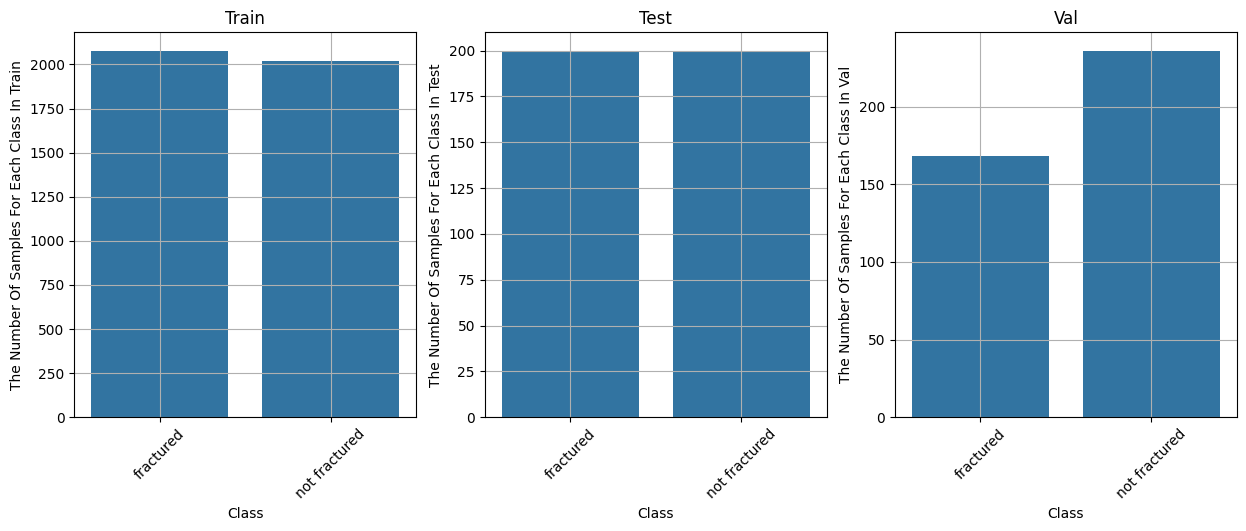

In [ ]:
# Visualizing the directories
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

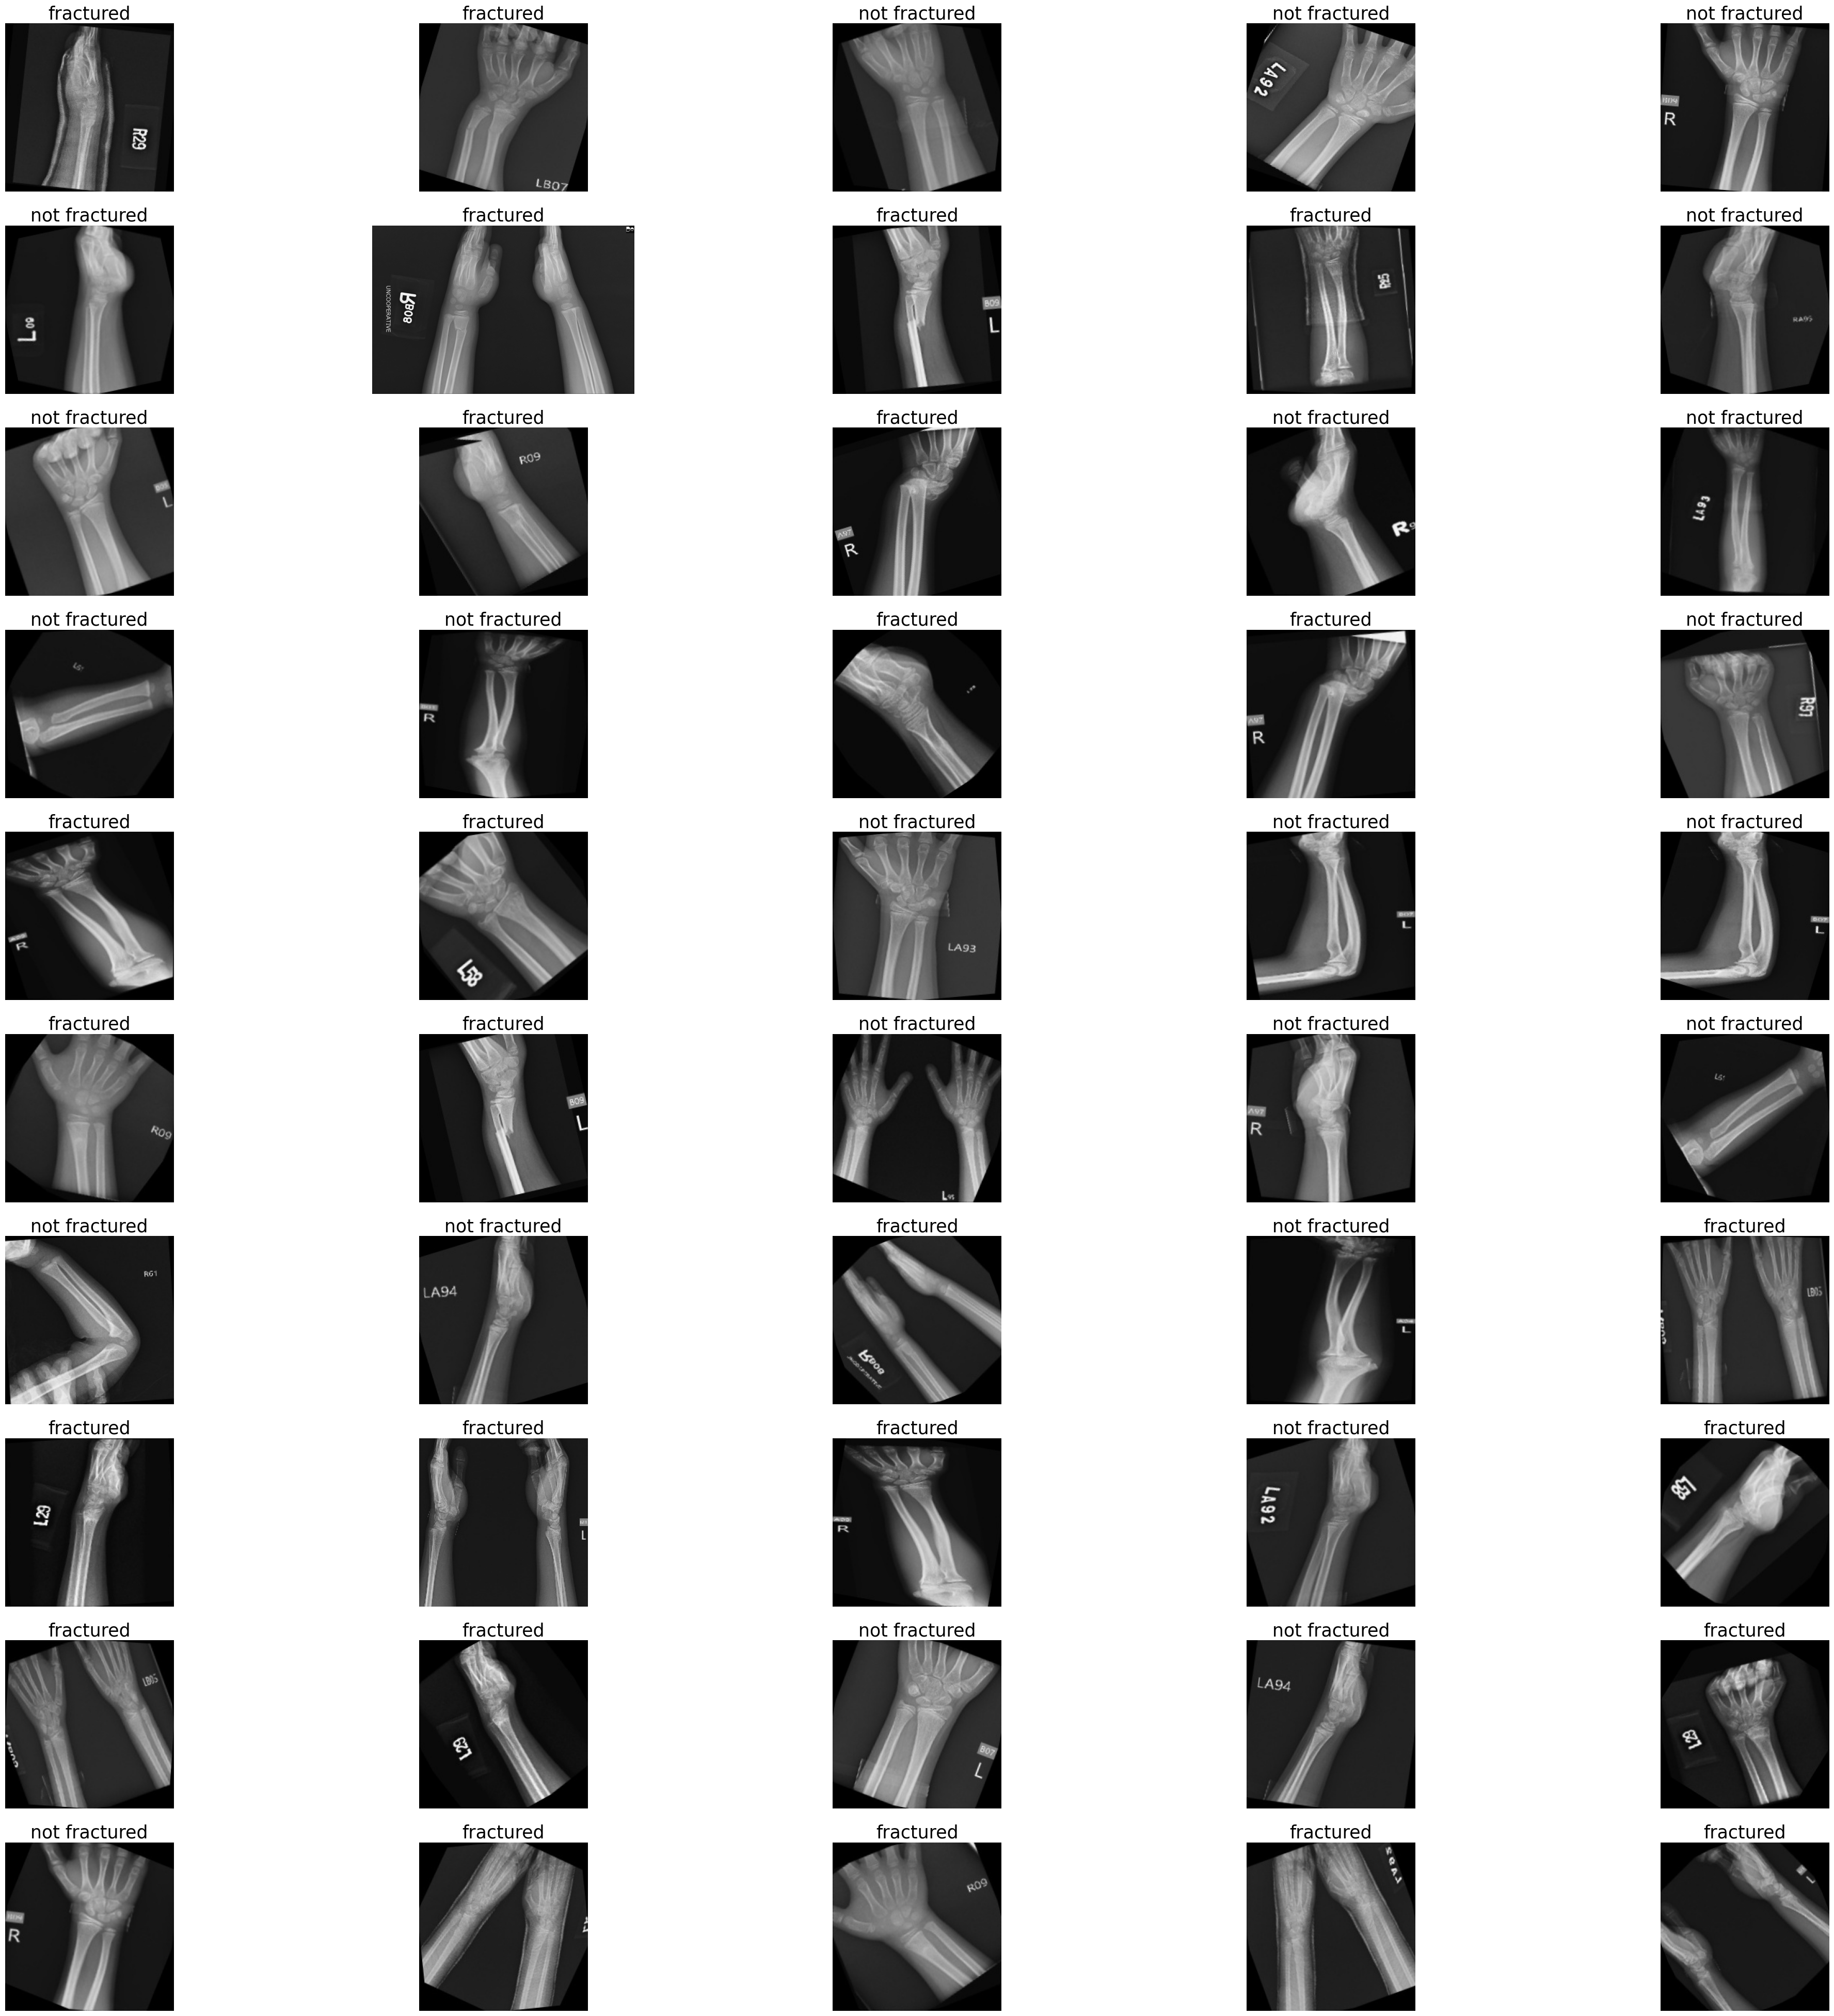

In [ ]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

In [ ]:
# Performing Data Augmentation
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


In [ ]:
# Model Development

class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(128,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

checkpoint_cb = ModelCheckpoint("bone_fracture_detection_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 728s 6s/step - accuracy: 0.7005 - auc: 0.7407 - loss: 4.3176 - specificity_at_sensitivity: 0.8031 - val_accuracy: 0.5842 - val_auc: 0.5000 - val_loss: 7.1180 - val_specificity_at_sensitivity: 0.0000e+00
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 735s 6s/step - accuracy: 0.8420 - auc: 0.8911 - loss: 1.2334 - specificity_at_sensitivity: 0.9203 - val_accuracy: 0.6386 - val_auc: 0.7794 - val_loss: 1.3216 - val_specificity_at_sensitivity: 0.8393
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 734s 6s/step - accuracy: 0.9039 - auc: 0.9511 - loss: 0.5376 - specificity_at_sensitivity: 0.9692 - val_accuracy: 0.7203 - val_auc: 0.7717 - val_loss: 1.6119 - val_specificity_at_sensitivity: 0.8036
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 718s 6s/step - accuracy: 0.9427 - auc: 0.9737 - loss: 0.2804 - specificity_at_sensitivity: 0.9825 - val_accuracy: 0.8515 - val_auc: 0.8867 - val_loss: 0.8285 - val_specificity_at_sensitivity: 0.8393
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 733s 6s/ste

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy       auc      loss  specificity_at_sensitivity  val_accuracy  \
0  0.749573  0.794250  2.907297                    0.846968      0.584158   
1  0.861850  0.910859  0.970901                    0.935034      0.638614   
2  0.907737  0.954640  0.499932                    0.971607      0.720297   
3  0.947523  0.977089  0.252171                    0.982676      0.851485   
4  0.962412  0.988772  0.151921                    0.993263      0.955446   
5  0.969002  0.990508  0.131691                    0.992300      0.987624   
6  0.975836  0.993973  0.090533                    0.995669      0.995049   
7  0.978277  0.994031  0.089603                    0.994706      0.990099   
8  0.976568  0.991729  0.118418                    0.992300      0.990099   
9  0.981694  0.993799  0.079103                    0.993744      1.000000   

    val_auc  val_loss  val_specificity_at_sensitivity  
0  0.500000  7.117983                        0.000000  
1  0.779384  1.321560                        0.839286  
2  0.771729  1.611910                        0.803571  
3  0.886741  0.828477                        0.839286  
4  0.990012  0.154025                        0.982143  
5  1.000000  0.027172                        1.000000  
6  1.000000  0.006473                        1.000000  
7  0.999647  0.029921                        1.000000  
8  0.999975  0.022308                        1.000000  
9  1.000000  0.001413                        1.000000

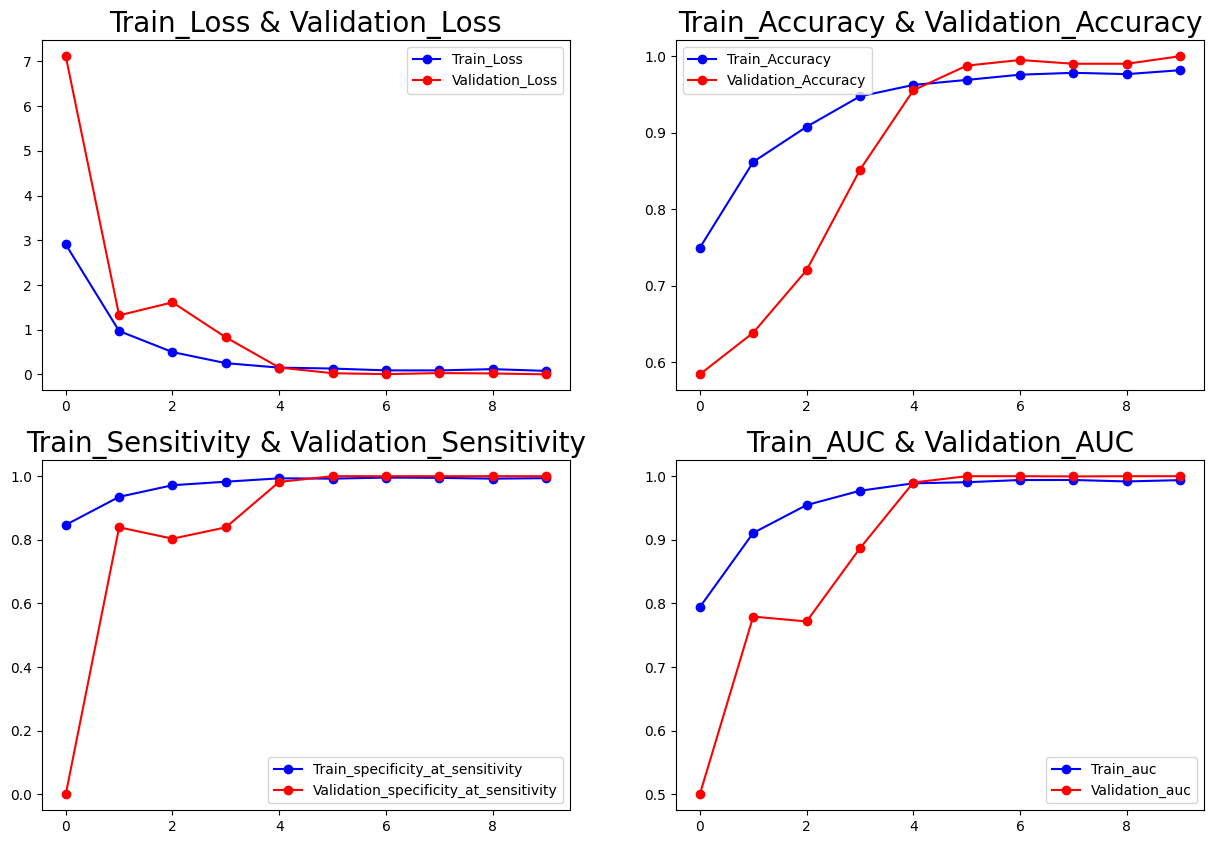

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9988 - auc: 0.5714 - loss: 0.0019 - specificity_at_sensitivity: 0.5714
Test Loss = 0.0038637586403638124
Test Accuracy = 0.9974937438964844
Test Sensitivity = 1.0
Test AUC = 1.0


In [ ]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)


13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9988 - auc: 0.5714 - loss: 0.0019 - specificity_at_sensitivity: 0.5714
Test Accuracy = 0.9974937438964844
Test Sensitivity = 1.0


In [ ]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
394       1           1
395       1           1
396       1           1
397       1           1
398       1           1

[399 rows x 2 columns]

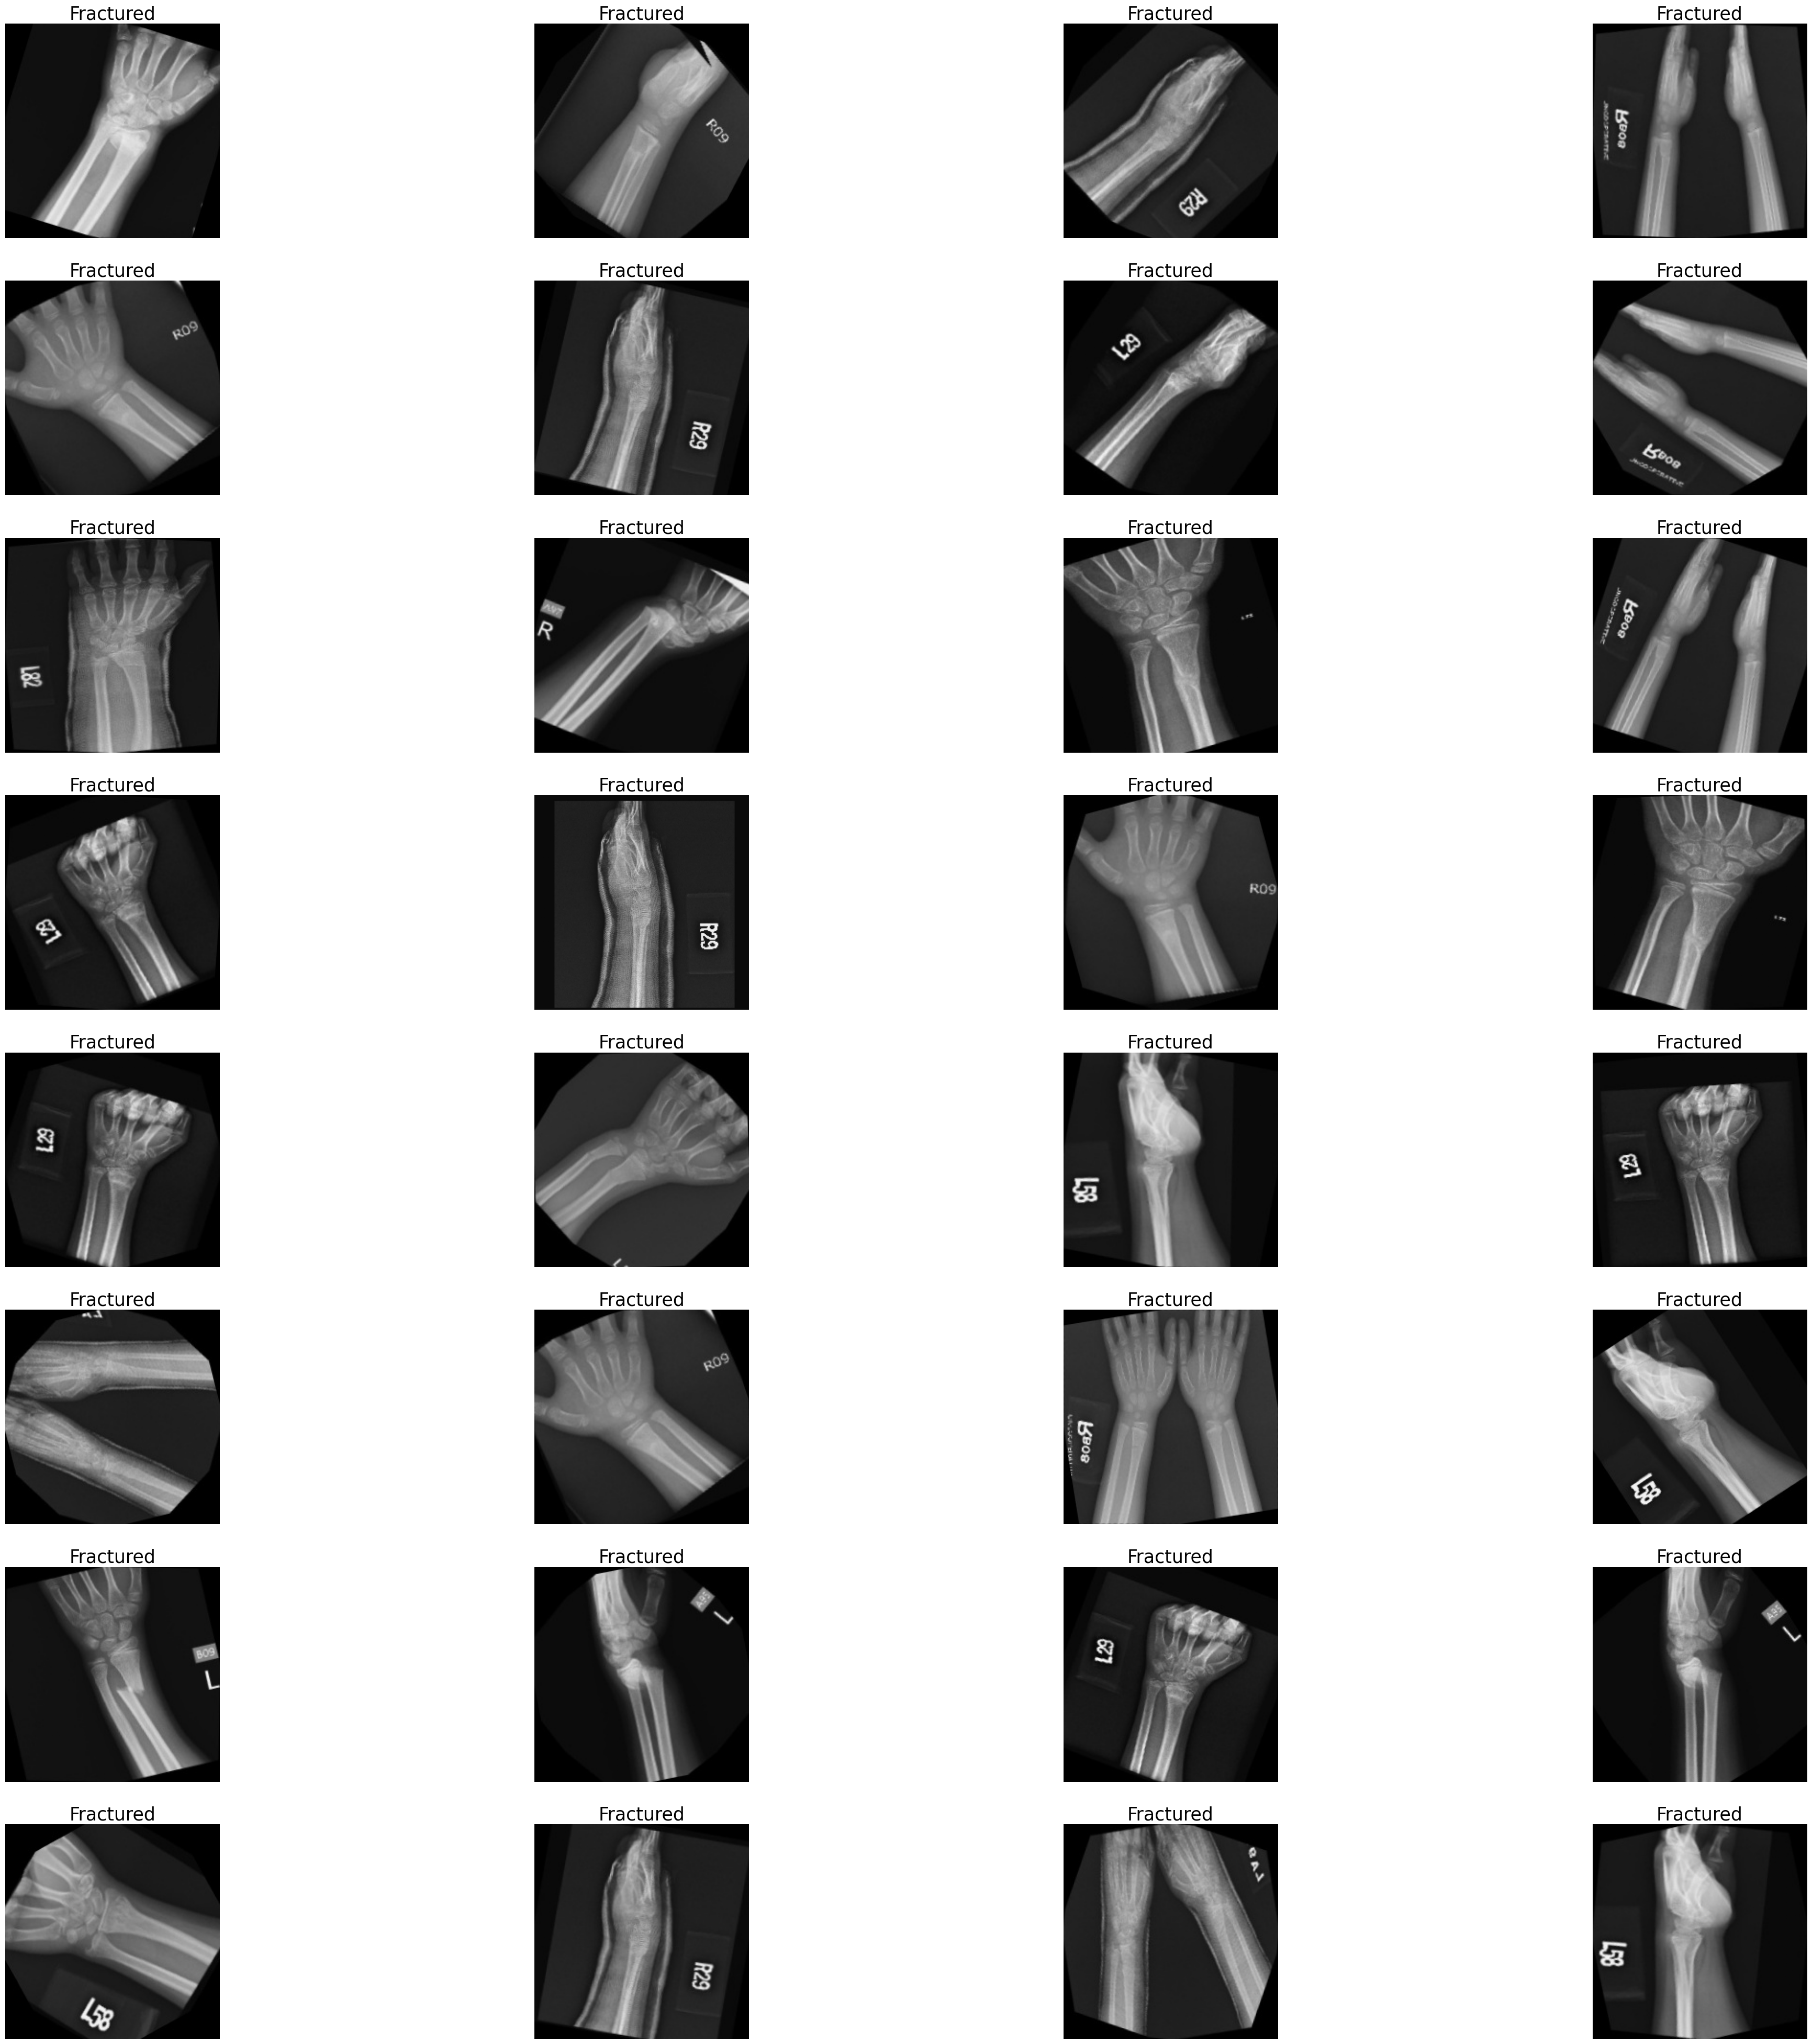

In [ ]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[199,   0],
       [  1, 199]])

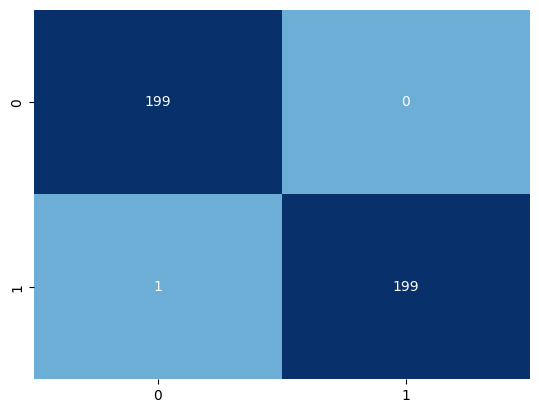

In [ ]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      1.00      1.00       199
           1       1.00      0.99      1.00       200

    accuracy                           1.00       399
   macro avg       1.00      1.00      1.00       399
weighted avg       1.00      1.00      1.00       399

